In [1]:
import pandas as pd 

In [2]:
# Load the preprocessed dataset
file_path = r"C:\Users\getmu\Downloads\cnn daily mail c;leaned datset.csv"
df = pd.read_csv(file_path)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:

# Check the first few rows of the dataset
print(df.head(5))

                                         id  \
0  0001d1afc246a7964130f43ae940af6bc6c57f01   
1  0002095e55fcbd3a2f366d9bf92a95433dc305ef   
2  00027e965c8264c35cc1bc55556db388da82b07f   
3  0002c17436637c4fe1837c935c04de47adb18e9a   
4  0003ad6ef0c37534f80b55b4235108024b407f0b   

                                             article  \
0  associated press publish est october update es...   
1  cnn ralph mata internal affairs lieutenant mia...   
2  drunk driver kill young woman headon crash che...   
3  cnn breezy sweep pen president vladimir putin ...   
4  fleetwood team still record sky bet league one...   

                                          highlights  
0  bishop john folda north dakota taking time dia...  
1  criminal complaint cop use role help cocaine t...  
2  craig ecclestontodd drunk least three pint dri...  
3  nina dos santos say europe must ready accept s...  
4  fleetwood top league one win scunthorpe peterb...  


In [ ]:
# Analyze the distribution of text lengths in the articles and highlights
df['article_length'] = df['article'].apply(lambda x: len(x.split()))
df['highlights_length'] = df['highlights'].apply(lambda x: len(x.split()))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


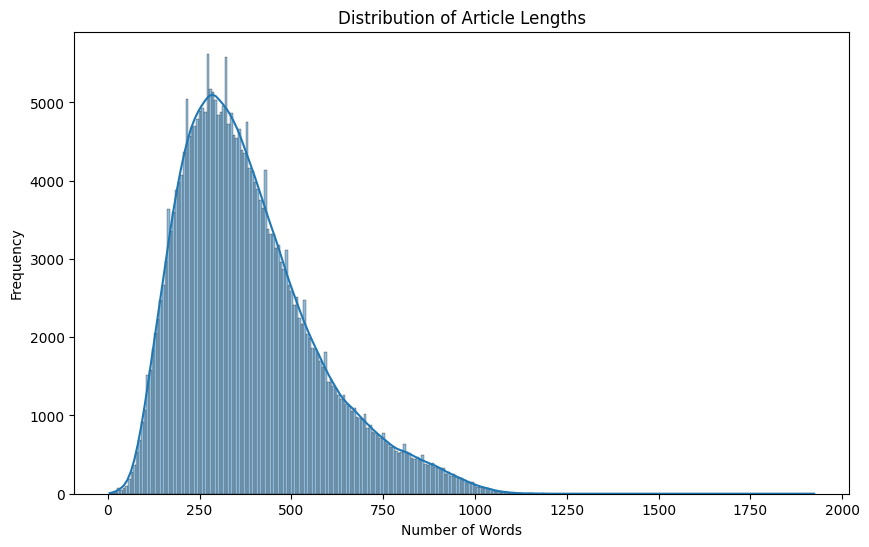

In [ ]:
# Plot the distribution of article lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['article_length'], kde=True)
plt.title('Distribution of Article Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

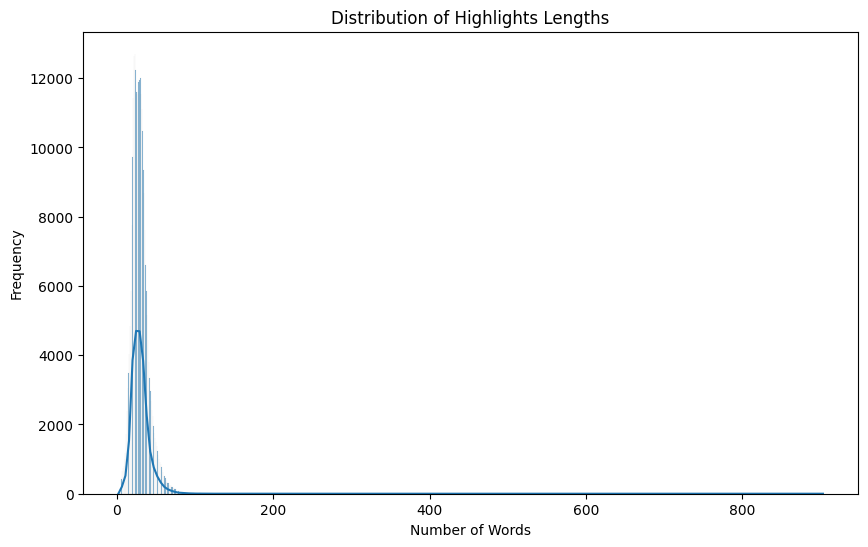

In [ ]:

# Plot the distribution of highlights lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['highlights_length'], kde=True)
plt.title('Distribution of Highlights Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [ ]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['article'])

In [ ]:

X_sequences = tokenizer.texts_to_sequences(df['article'])
y_sequences = tokenizer.texts_to_sequences(df['highlights'])

In [ ]:
# Set padding lengths based on analysis
max_len_X = 500  # for articles
max_len_y = 50   # for highlights

In [ ]:
X_padded = pad_sequences(X_sequences, maxlen=max_len_X, padding='post', truncating='post')
y_padded = pad_sequences(y_sequences, maxlen=max_len_y, padding='post', truncating='post')


In [ ]:
X_padded = pad_sequences(X_sequences, maxlen=max_len_X, padding='post', truncating='post')
y_padded = pad_sequences(y_sequences, maxlen=max_len_y, padding='post', truncating='post')


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, TimeDistributed
from tensorflow.keras.models import Model

In [ ]:
# Example configuration
vocab_size = 10000  # Size of the vocabulary
embedding_dim = 128  # Embedding dimensions
latent_dim = 256  # Number of LSTM units
max_len_X = 500  # Max length of input sequence (articles)
max_len_y = 50   # Max length of output sequence (summaries)

In [ ]:
print(f"X_padded shape: {X_padded.shape}")
print(f"y_padded shape: {y_padded.shape}")

X_padded shape: (287113, 500)
y_padded shape: (287113, 50)


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
import tensorflow as tf                     # For building and training the neural network model
from tensorflow.keras import layers         # For using different layers in the model
from tensorflow.keras.models import Model   # For creating the Model class
from tensorflow.keras.optimizers import Adam # For using the Adam optimizer
import pickle 

In [ ]:
# Encoder
encoder_inputs = Input(shape=(max_len_X,))
encoder_embedding = Embedding(vocab_size, embedding_dim, input_length=max_len_X)(encoder_inputs)
encoder_lstm, state_h, state_c = LSTM(latent_dim, return_state=True, return_sequences=True)(encoder_embedding)

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(vocab_size, embedding_dim)(decoder_inputs)
decoder_lstm, _, _ = LSTM(latent_dim, return_state=True, return_sequences=True)(decoder_embedding, initial_state=[state_h, state_c])

# Attention Mechanism
attention = tf.keras.layers.Attention()
context_vector = attention([decoder_lstm, encoder_lstm])

# Concatenate context vector with the decoder LSTM output
decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_lstm])

# Output Dense layer
decoder_outputs = TimeDistributed(Dense(embedding_dim, activation="relu"))(decoder_combined_context)
decoder_outputs = Dense(vocab_size, activation='softmax')(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)



c:\text_Summerization_app\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 500, 128)  │  1,280,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 128) │  1,280,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 500,      │    394,240 │ embedding[0][0]   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │    394,240 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ lstm[0][1],       │
│                     │ 256), (None,      │            │ lstm[0][2]        │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, None, 256) │          0 │ lstm_1[0][0],     │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 512) │          0 │ attention[0][0],  │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None, 128) │     65,664 │ concatenate[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None,      │  1,290,000 │ time_distributed… │
│                     │ 10000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,704,144 (17.94 MB)

 Trainable params: 4,704,144 (17.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import streamlit as st
import tensorflow as tf
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
import tensorflow as tf
import pickle

# Assuming 'model' is your trained model and 'tokenizer' is your tokenizer object

# Save the trained model to an H5 file
model.save('text_exploration.h5')

# Save the tokenizer to a pickle file
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
